In [35]:
import xarray as xr
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [36]:
ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/all_models.nc')

# Define the models to drop
models_to_drop = ['MMM', 'MCA']

# Select only the models that are not in the list
ds = ds.drop_vars(models_to_drop)
ds

<xarray.Dataset> Size: 1MB
Dimensions:      (lev: 43, lon: 360)
Coordinates:
  * lev          (lev) float32 172B 5.0 15.0 25.0 ... 1.245e+03 1.4e+03
  * lon          (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
Data variables: (12/14)
    CCSM4        (lev, lon) float64 124kB ...
    CESM1.2      (lev, lon) float32 62kB ...
    CESM2        (lev, lon) float32 62kB ...
    COSMOS       (lev, lon) float64 124kB ...
    EC_Earth3.3  (lev, lon) float32 62kB ...
    HADGEM3      (lev, lon) float64 124kB ...
    ...           ...
    IPSLCM6A     (lev, lon) float32 62kB ...
    GISS         (lev, lon) float64 124kB ...
    LEEDS        (lev, lon) float64 124kB ...
    NorESM-F     (lev, lon) float64 124kB ...
    IPSLCM5A     (lev, lon) float32 62kB ...
    IPSLCM5A2    (lev, lon) float32 62kB ...

--------------------------------------------------------------------------------------------
Original data shape: (15480, 14), Cleaned data shape: (10409, 14)
--------------------------------------------------------------------------------------------
PCA completed successfully after NaN removal!
<xarray.Dataset> Size: 619kB
Dimensions:  (lev: 43, lon: 360)
Dimensions without coordinates: lev, lon
Data variables:
    PC1      (lev, lon) float64 124kB nan nan nan nan nan ... nan nan nan nan
    PC2      (lev, lon) float64 124kB nan nan nan nan nan ... nan nan nan nan
    PC3      (lev, lon) float64 124kB nan nan nan nan nan ... nan nan nan nan
    PC4      (lev, lon) float64 124kB nan nan nan nan nan ... nan nan nan nan
    PC5      (lev, lon) float64 124kB nan nan nan nan nan ... nan nan nan nan
[0.35045011 0.24366413 0.1328793  0.1024397  0.04442386]


/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/1347223073.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  f'PC{i+1}': (['lev', 'lon'], restored_pca[:, i].reshape(ds.dims['lev'], ds.dims['lon']))


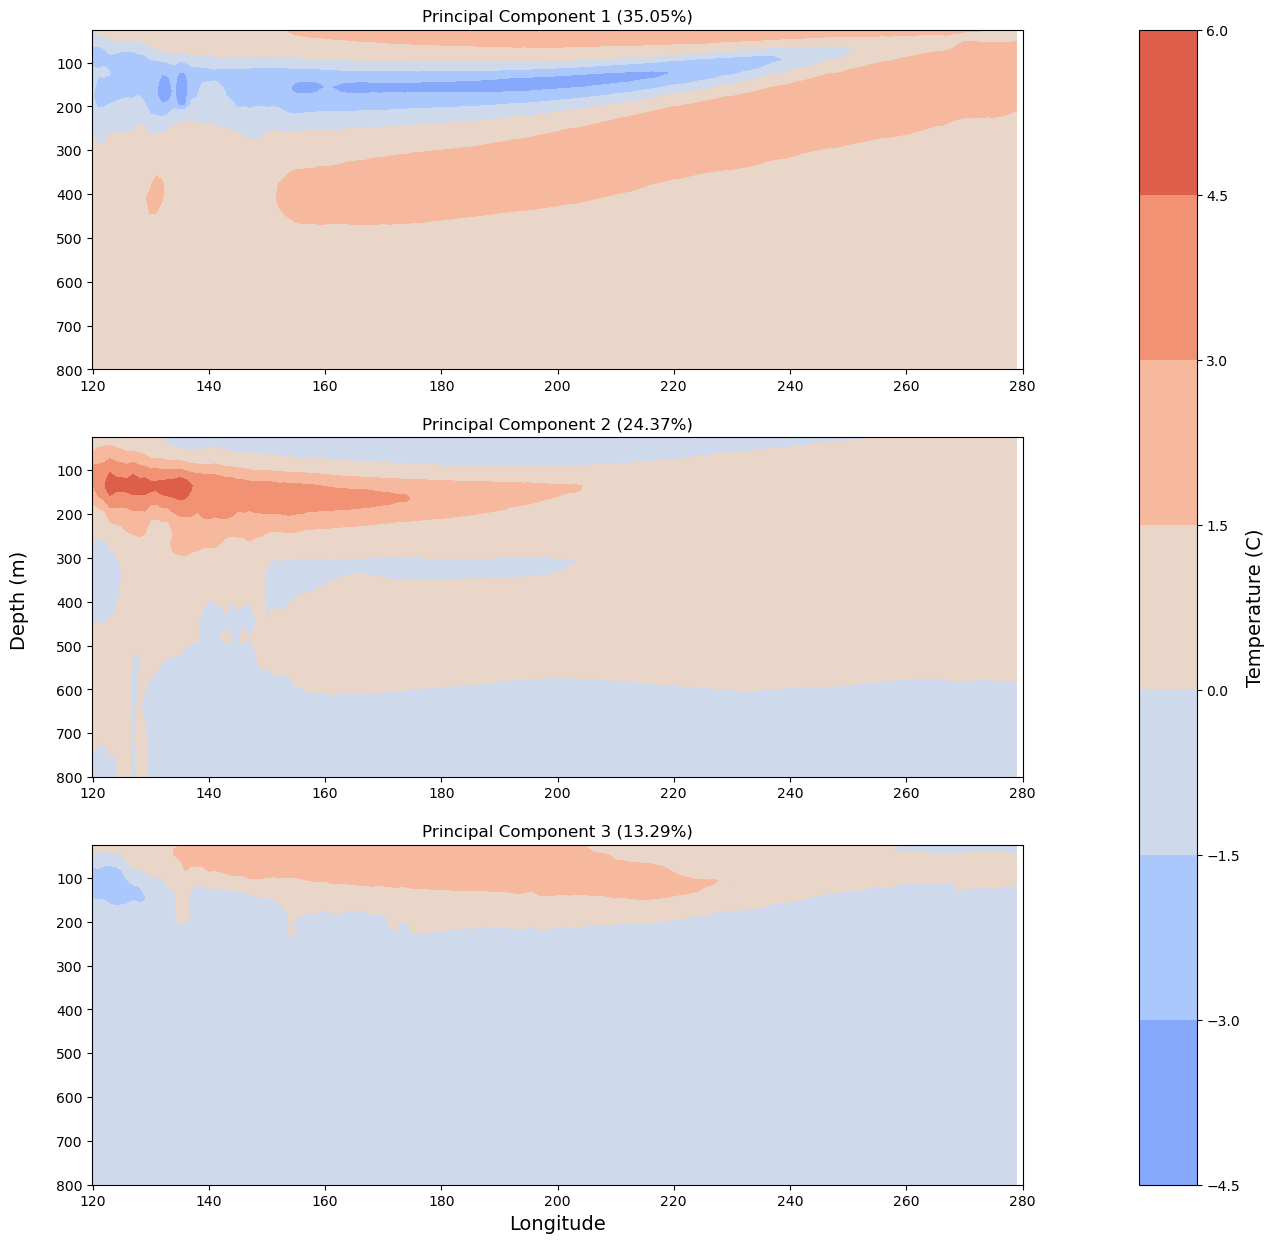

In [37]:
# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]
print ('--------------------------------------------------------------------------------------------')
print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")
print ('--------------------------------------------------------------------------------------------')
# Perform PCA on cleaned data
pca = PCA(n_components=5)
pca_result = pca.fit_transform(clean_data_matrix)

# Reconstruct into original grid (without NaN rows)
restored_pca = np.full((data_matrix.shape[0], pca_result.shape[1]), np.nan)  # Placeholder with NaNs
restored_pca[~nan_mask] = pca_result  # Fill only valid positions

# Convert back to xarray
pca_ds = xr.Dataset({
    f'PC{i+1}': (['lev', 'lon'], restored_pca[:, i].reshape(ds.dims['lev'], ds.dims['lon']))
    for i in range(pca_result.shape[1])
})
pca_ds.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/pca_results.nc')

print("PCA completed successfully after NaN removal!")

print(pca_ds)
print(pca.explained_variance_ratio_)

# Define number of PCs to visualize
num_components = min(3, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

# Initialize a variable to store the last mappable object
last_pcm = None

for i in range(num_components):
    ax = axes[i]
    norm = plt.Normalize(vmin=-7, vmax=7)
    # Plot PCA result as an image (Depth vs. Longitude)
    pcm = ax.contourf(ds['lon'], ds['lev'], pca_ds[f'PC{i+1}'], cmap='coolwarm', norm=norm)
    last_pcm = pcm  # Store the last mappable object
    
    # Formatting
    ax.set_title(f'Principal Component {i+1} ({variance[i]:.2f}%)')
    ax.set_ylim([800, 25])
    ax.set_xlim([120, 280])

# Add a single colorbar for all subplots
cbar = fig.colorbar(last_pcm, ax=axes, orientation='vertical', fraction=0.1, pad=0.1, location='right')
ax.set_xlabel('Longitude', fontsize = 14)
fig.supylabel('Depth (m)', fontsize=14, x = 0.07)

cbar.set_label('Temperature (C)', fontsize=14,)
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/PCA_DepthvsLongitude_04102025.pdf', dpi=300, bbox_inches="tight")
plt.show()

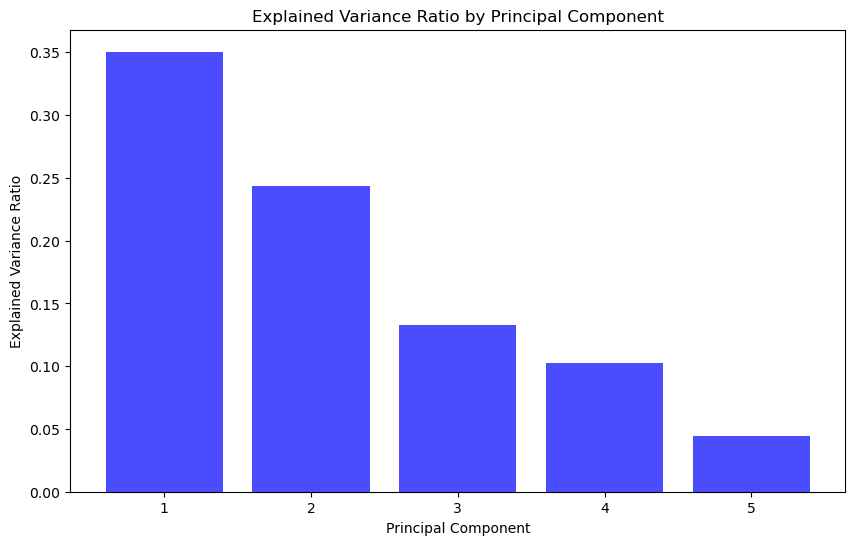

In [6]:
# Assuming pca.explained_variance_ratio_ is already computed
explained_variance_ratios = pca.explained_variance_ratio_

# Number of components
num_components = len(explained_variance_ratios)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_components + 1), explained_variance_ratios, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, num_components + 1))

plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/explained_variance_ratio_by_PC.pdf', dpi=300, bbox_inches="tight")
plt.show()

Original data shape: (15480, 14), Cleaned data shape: (10409, 14)


/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/3208055680.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_models, rotation=45, ha='right')
/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/3208055680.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_models, rotation=45, ha='right')
/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/3208055680.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_models, rotation=45, ha='right')


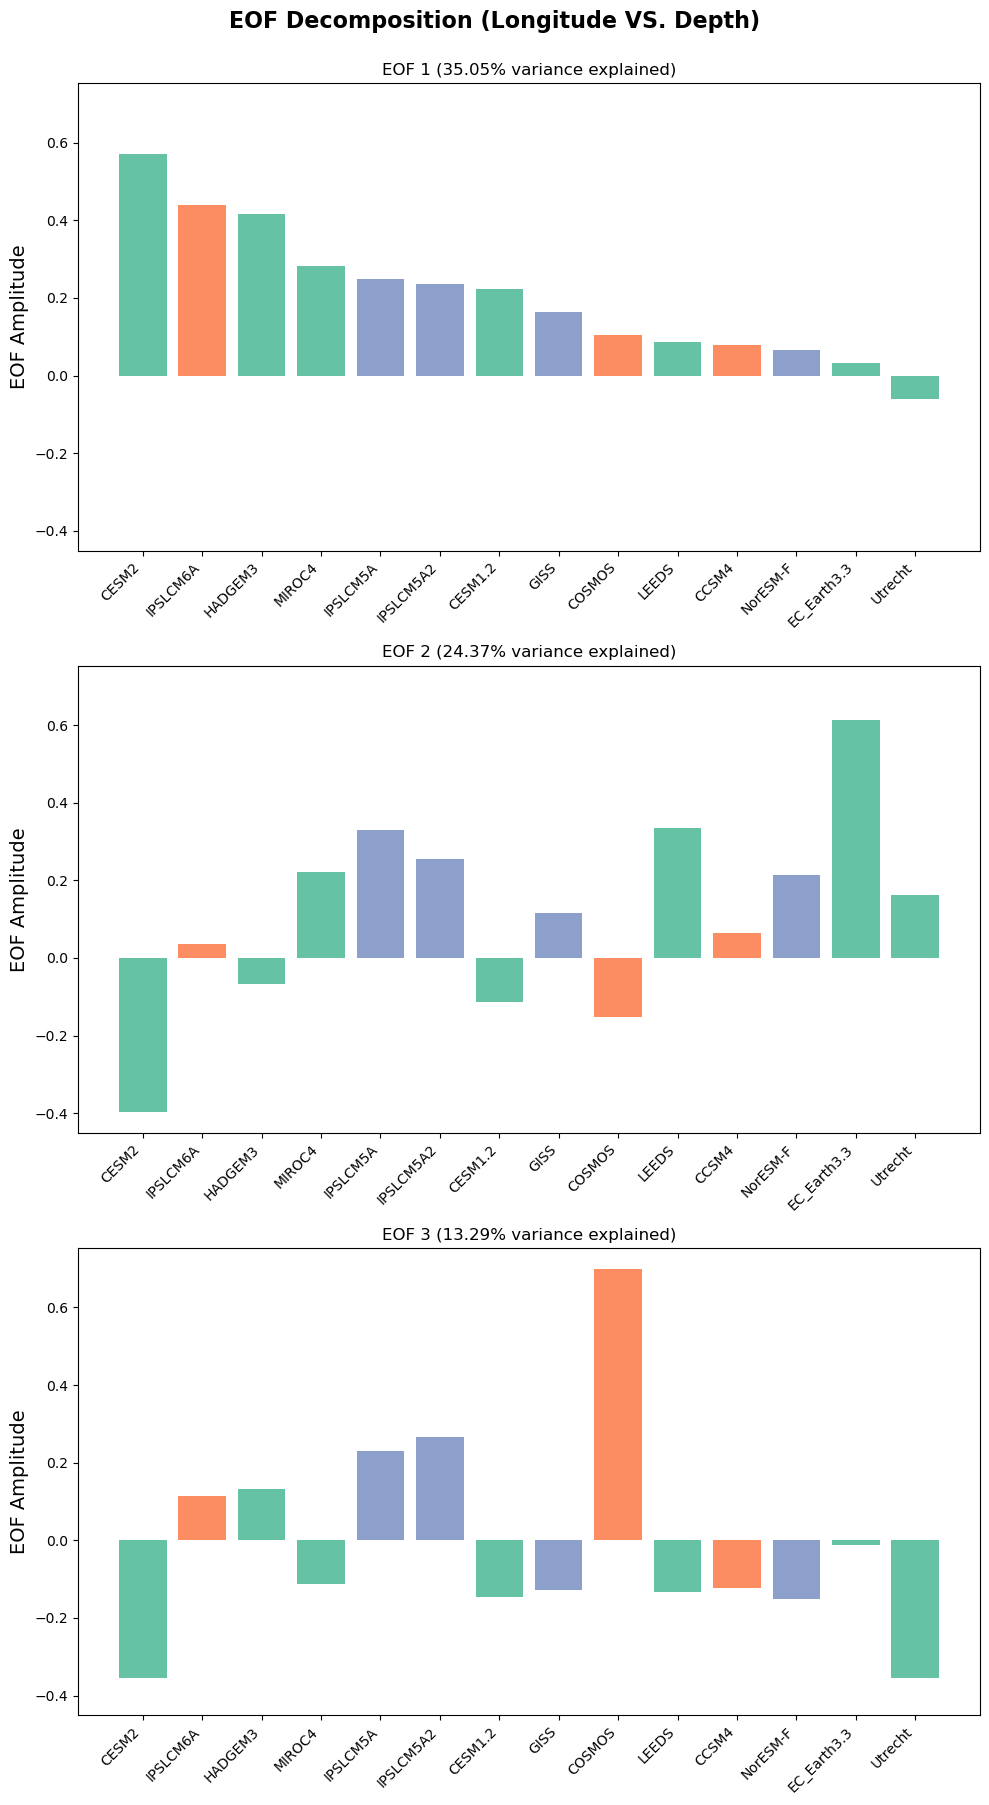

In [23]:
# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")

# Perform EOF Analysis
pca = PCA(n_components=3)
pca_result = pca.fit_transform(clean_data_matrix)
EOFs = pca.components_

# Convert EOFs back to xarray
eof_ds = xr.Dataset({
    f'EOF{i+1}': (['model'], EOFs[i])
    for i in range(EOFs.shape[0])
}, coords={'model': models_to_keep})

# Define number of EOFs to visualize
num_components = min(5, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(10, 18), sharey=True)

# FIRST: Get the sorting order from EOF1
eof1_values = eof_ds['EOF1'].values
sorted_indices = np.argsort(eof1_values)[::-1]  # Descending order
sorted_models = np.array(models_to_keep)[sorted_indices]

# Define models to highlight and their colors
highlight_models = {
    'CESM2': '#66c2a5',
    'CESM1.2': '#66c2a5',
    'EC_Earth3.3': '#66c2a5',
    'HADGEM3': '#66c2a5',
    'MIROC4': '#66c2a5',
    'Utrecht': '#66c2a5',
    'LEEDS': '#66c2a5',
    'CCSM4': '#fc8d62',
    'COSMOS': '#fc8d62',
    'IPSLCM6A': '#fc8d62',
    'GISS': '#8da0cb',
    'NorESM-F': '#8da0cb',
    'IPSLCM5A': '#8da0cb',
    'IPSLCM5A2': '#8da0cb',
    
}

# Modify the plotting loop
for i in range(num_components):
    ax = axes[i]
    
    # Get values in EOF1-sorted order
    sorted_eof_values = eof_ds[f'EOF{i+1}'].values[sorted_indices]
    
    # Assign colors: default 'steelblue', but use highlight_models if specified
    colors = [highlight_models.get(model, 'steelblue') for model in sorted_models]
    
    # Plot with color coding
    bars = ax.bar(sorted_models, sorted_eof_values, color=colors)
    
    # (Rest of the formatting remains the same)
    ax.set_title(f'EOF {i+1} ({variance[i]:.2f}% variance explained)')
    ax.set_ylabel('EOF Amplitude', fontsize=14)
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')

fig.suptitle('EOF Decomposition (Longitude VS. Depth)', 
             fontsize=16, fontweight='bold', y=1)

plt.tight_layout()
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Deconposition_LongitudeVSDepth.pdf', 
            dpi=300, bbox_inches="tight")
plt.show()

Cluster 1: ['CESM2', 'HADGEM3']
Cluster 2: ['CCSM4', 'CESM1.2', 'EC_Earth3.3', 'MIROC4', 'Utrecht', 'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']
Cluster 3: ['COSMOS']


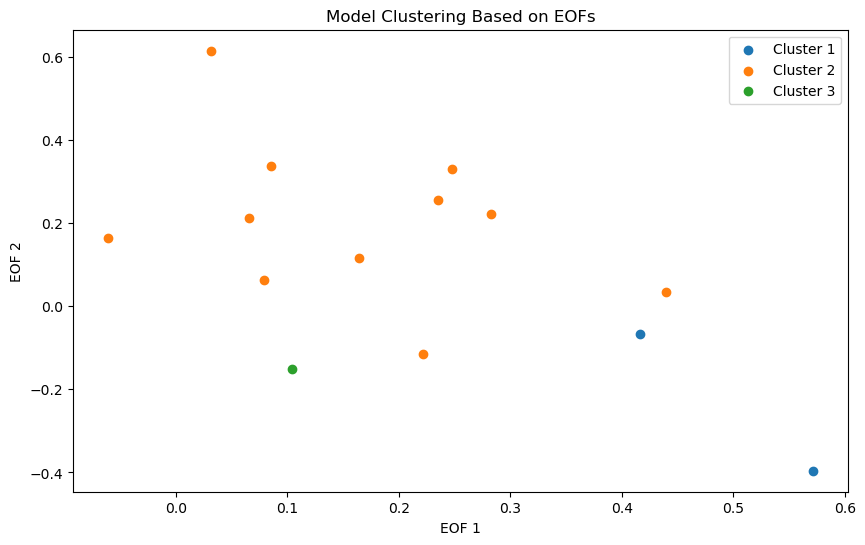

In [26]:
# Use the EOFs as features for clustering
num_clusters = 3  # Define the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(EOFs.T)  # Transpose so models are in rows

# Add cluster labels to xarray Dataset
eof_ds['Cluster'] = (['model'], clusters)

# Print model clusters
for cluster in range(num_clusters):
    grouped_models = [models_to_keep[i] for i in range(len(models_to_keep)) if clusters[i] == cluster]
    print(f"Cluster {cluster+1}: {grouped_models}")

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_idx = (clusters == i)
    plt.scatter(EOFs[0, cluster_idx], EOFs[1, cluster_idx], label=f'Cluster {i+1}')

plt.xlabel('EOF 1')
plt.ylabel('EOF 2')
plt.title('Model Clustering Based on EOFs')
plt.legend()
plt.show()

Cluster 1: ['CESM2', 'HADGEM3']
Cluster 2: ['CCSM4', 'CESM1.2', 'EC_Earth3.3', 'MIROC4', 'Utrecht', 'IPSLCM6A', 'GISS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']
Cluster 3: ['COSMOS']
Cluster 4: ['LEEDS']


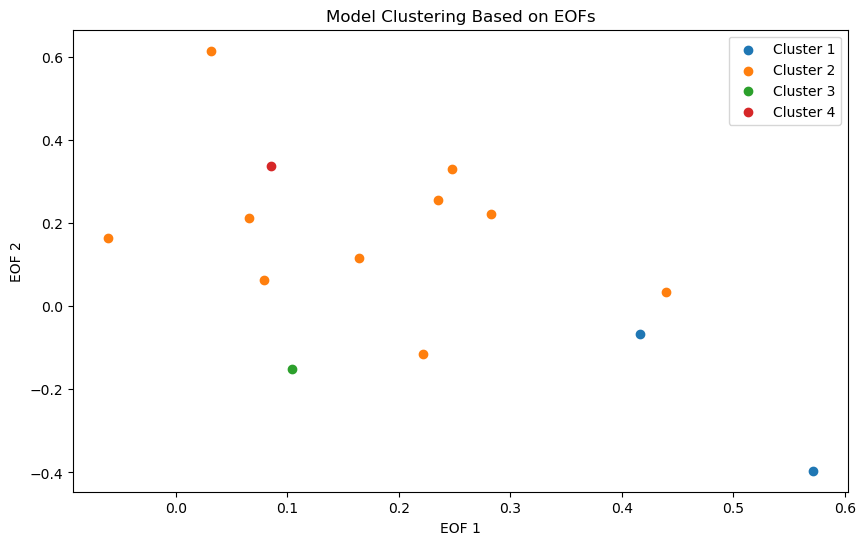

In [27]:
# Use the EOFs as features for clustering
num_clusters = 4  # Define the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(EOFs.T)  # Transpose so models are in rows

# Add cluster labels to xarray Dataset
eof_ds['Cluster'] = (['model'], clusters)

# Print model clusters
for cluster in range(num_clusters):
    grouped_models = [models_to_keep[i] for i in range(len(models_to_keep)) if clusters[i] == cluster]
    print(f"Cluster {cluster+1}: {grouped_models}")

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_idx = (clusters == i)
    plt.scatter(EOFs[0, cluster_idx], EOFs[1, cluster_idx], label=f'Cluster {i+1}')

plt.xlabel('EOF 1')
plt.ylabel('EOF 2')
plt.title('Model Clustering Based on EOFs')
plt.legend()
plt.show()

Cluster 1: ['CESM2', 'HADGEM3']
Cluster 2: ['CCSM4', 'CESM1.2', 'MIROC4', 'Utrecht', 'GISS', 'NorESM-F']
Cluster 3: ['COSMOS']
Cluster 4: ['LEEDS']
Cluster 5: ['EC_Earth3.3', 'IPSLCM6A', 'IPSLCM5A', 'IPSLCM5A2']


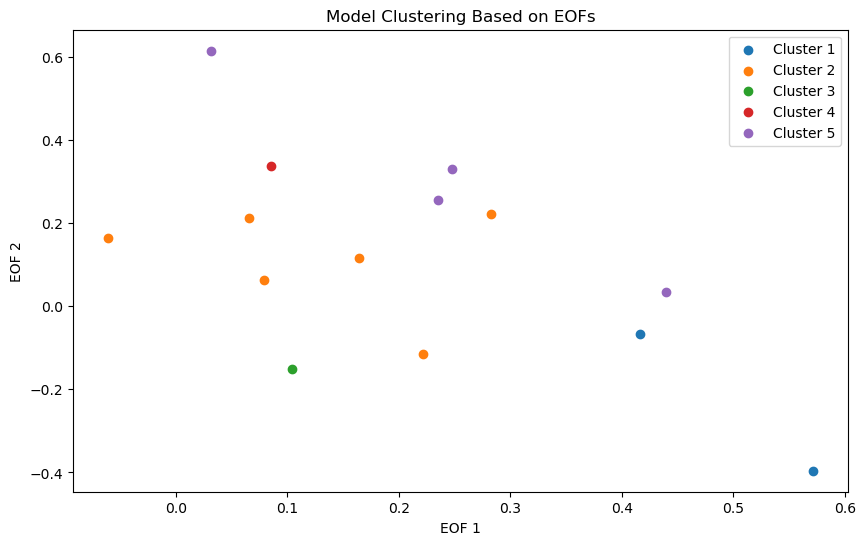

In [28]:
# Use the EOFs as features for clustering
num_clusters = 5  # Define the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(EOFs.T)  # Transpose so models are in rows

# Add cluster labels to xarray Dataset
eof_ds['Cluster'] = (['model'], clusters)

# Print model clusters
for cluster in range(num_clusters):
    grouped_models = [models_to_keep[i] for i in range(len(models_to_keep)) if clusters[i] == cluster]
    print(f"Cluster {cluster+1}: {grouped_models}")

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_idx = (clusters == i)
    plt.scatter(EOFs[0, cluster_idx], EOFs[1, cluster_idx], label=f'Cluster {i+1}')

plt.xlabel('EOF 1')
plt.ylabel('EOF 2')
plt.title('Model Clustering Based on EOFs')
plt.legend()
plt.show()

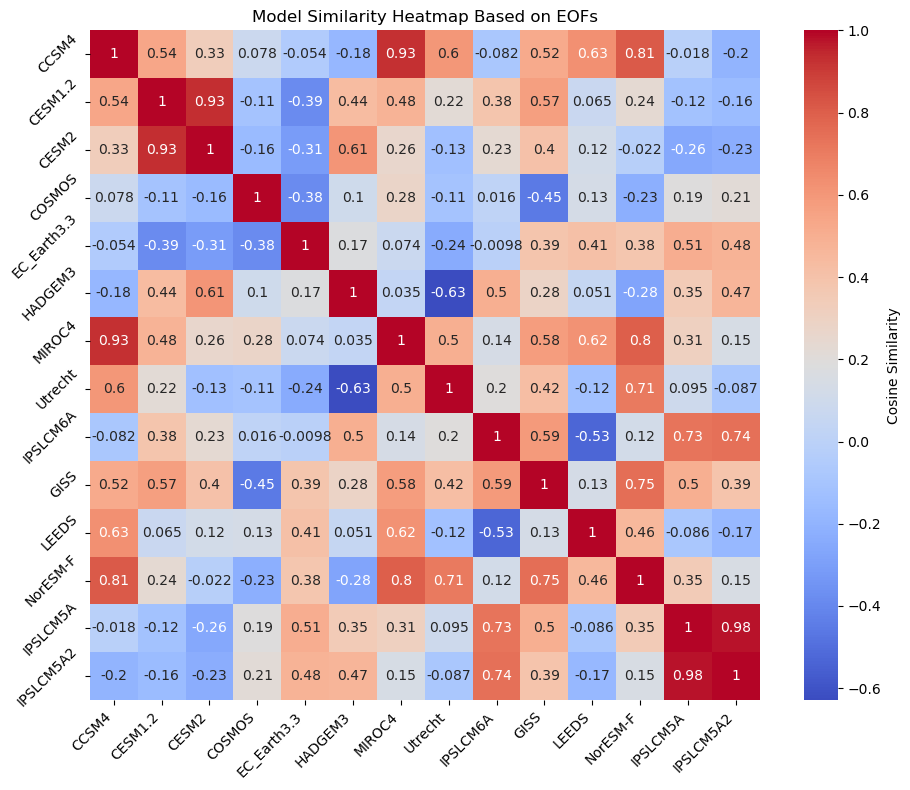

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Calculate cosine similarity between models based on their EOFs
similarity_matrix = cosine_similarity(EOFs.T)  # Transpose to have models in rows

# Create a heatmap of model similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=models_to_keep, yticklabels=models_to_keep,
            cbar_kws={'label': 'Cosine Similarity'}, square=True)
plt.title('Model Similarity Heatmap Based on EOFs')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/Model_Similarity_Heatmap.pdf', dpi=300, bbox_inches="tight")
plt.show()

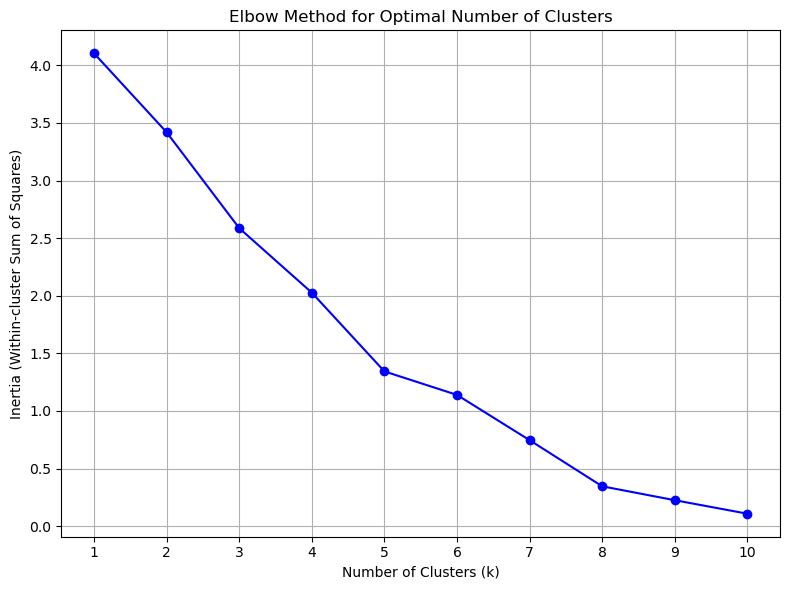

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of number of clusters to try
k_range = range(1, 11)  # Testing from 1 to 10 clusters
inertia_values = []

# Perform K-Means for each k and calculate inertia (WSS)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(EOFs.T)  # Fit on the transposed EOFs (models as rows)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

# Zonal Mean PCA

In [70]:
paths = "/glade/u/home/nwrye/OceanTemps_Compiles/Latlev Anomaly Files/"

anom_names = [
    "latlev_CCSM4_anomaly.nc",
    "latlev_CESM1.2_anomaly.nc",
    "latlev_CESM2_anomaly.nc",
    "latlev_COSMOS_anomaly.nc",
    "latlev_EC_Earth3.3_anomaly.nc",
    "latlev_HADGEM3_NEW_1997_anomaly.nc",
    "latlev_MIROC4_2004_anomaly.nc",
    "latlev_Utrecht_CESM1.0.5_anomaly.nc",
    "latlev_IPSLCM6A_LR_anomaly.nc",
    "latlev_GISS_anomaly.nc",
    "latlev_LEEDS_anomaly.nc",
    "latlev_NorESM-F_anomaly.nc",
    "latlev_IPSLCM5A_anomaly.nc",
    "latlev_IPSLCM5A2_anomaly.nc",
]
datasets = []

for filename in anom_names:
    ds = xr.open_dataset(paths + filename)
    
    model_name = filename.replace("latlev_", "").replace("_anomaly.nc", "")
    
    # Drop the time dimension if it exists
    if "time" in ds.dims:
        ds = ds.drop_dims("time")
    
    # Rename TEMP to a model-specific name
    ds = ds.rename_vars({"TEMP": f"{model_name}"})
    
    datasets.append(ds)

# Merge all datasets into one
combined_ds = xr.merge(datasets)
combined_ds = combined_ds.drop_vars("time")
combined_ds.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/Latlev Anomaly Files/latlev_anom_models.nc')
combined_ds
#print(combined_ds.data_vars)

<xarray.Dataset> Size: 498kB
Dimensions:            (lev: 54, lat: 121)
Coordinates:
  * lev                (lev) float32 216B 5.0 15.0 25.0 ... 3.628e+03 3.876e+03
  * lat                (lat) float64 968B -60.0 -59.0 -58.0 ... 58.0 59.0 60.0
Data variables: (12/14)
    CCSM4              (lev, lat) float32 26kB ...
    CESM1.2            (lev, lat) float32 26kB ...
    CESM2              (lev, lat) float32 26kB ...
    COSMOS             (lev, lat) float64 52kB ...
    EC_Earth3.3        (lev, lat) float32 26kB ...
    HADGEM3_NEW_1997   (lev, lat) float64 52kB ...
    ...                 ...
    IPSLCM6A_LR        (lev, lat) float32 26kB ...
    GISS               (lev, lat) float64 52kB ...
    LEEDS              (lev, lat) float32 26kB ...
    NorESM-F           (lev, lat) float64 52kB ...
    IPSLCM5A           (lev, lat) float32 26kB ...
    IPSLCM5A2          (lev, lat) float32 26kB ...

--------------------------------------------------------------------------------------------
PCA completed successfully with latitude weighting!
--------------------------------------------------------------------------------------------
<xarray.Dataset> Size: 157kB
Dimensions:  (lev: 54, lat: 121)
Dimensions without coordinates: lev, lat
Data variables:
    PC1      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
    PC2      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
    PC3      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
--------------------------------------------------------------------------------------------
Explained variance ratio: [0.48629786 0.16027418 0.11504427]
--------------------------------------------------------------------------------------------


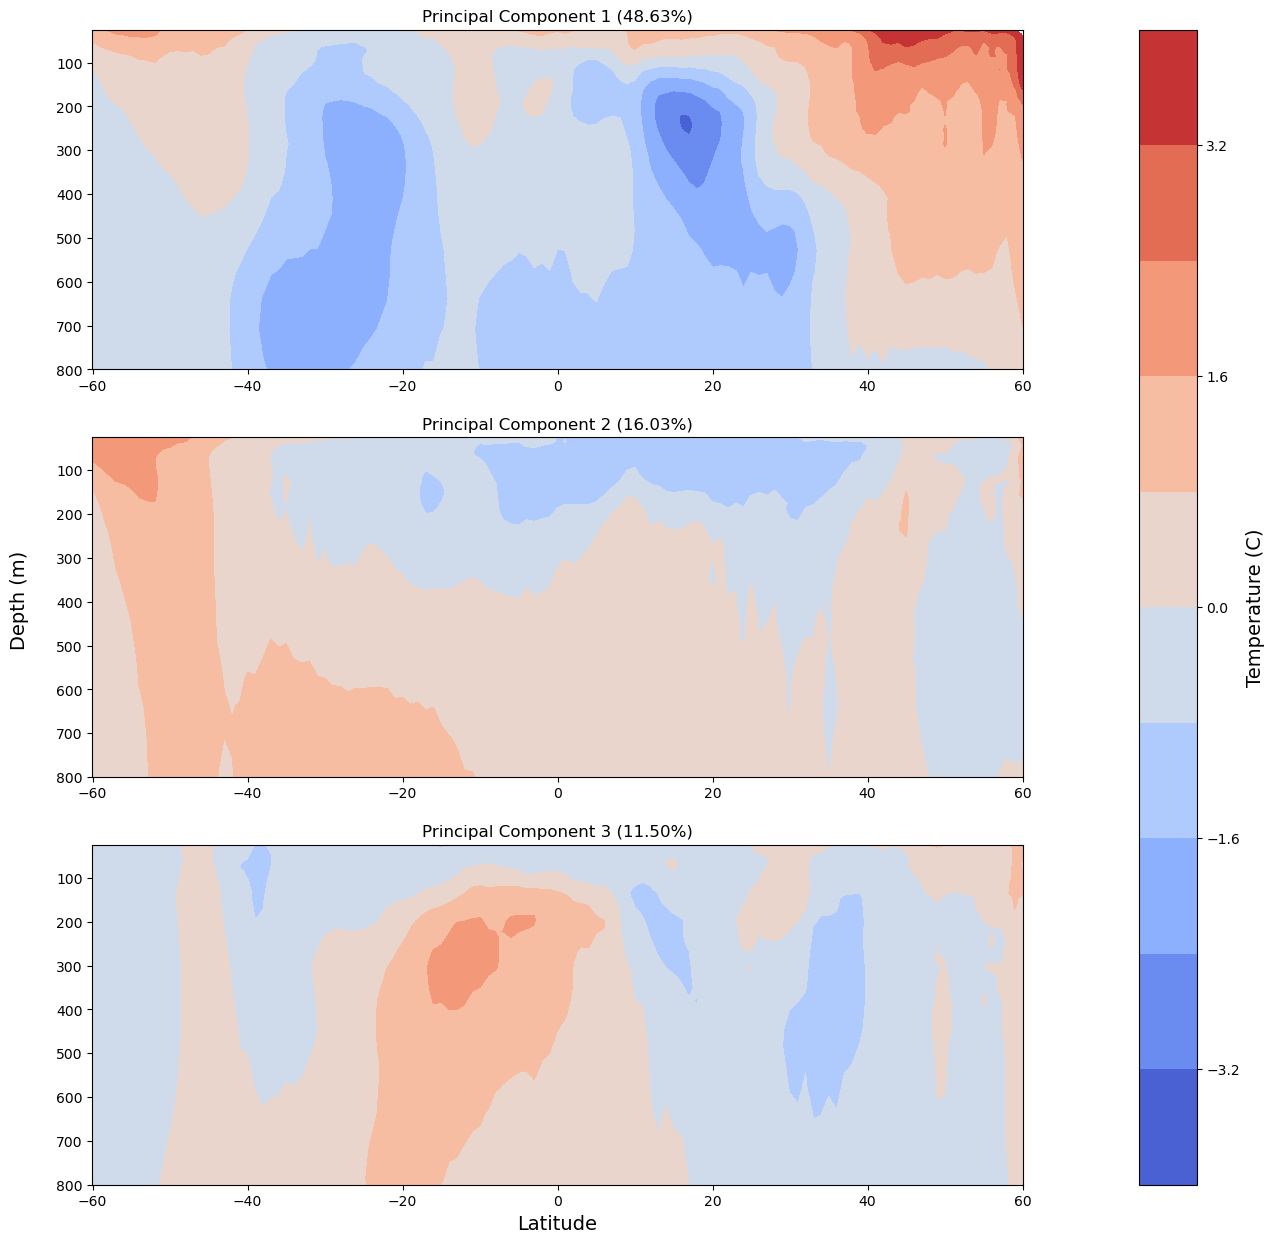

In [38]:
# Open dataset
ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Latlev Anomaly Files/latlev_anom_models.nc')

# Exclude unwanted models
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Remove NaN values
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

# Extract latitude values
latitudes = ds['lat'].values

# Compute latitude weights (sqrt of cosine of latitude)
lat_weights = np.sqrt(np.cos(np.radians(latitudes)))

# Expand weights to match the data structure
lat_weights_2d = np.tile(lat_weights[:, np.newaxis], (ds.sizes['lev'], 1))  
lat_weights_flat = lat_weights_2d.flatten()[~nan_mask]  # Flatten and apply NaN mask

# Apply latitude weighting to the data
weighted_data = clean_data_matrix * lat_weights_flat[:, np.newaxis]

# Perform PCA on weighted data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(weighted_data)

# Reconstruct into original grid
restored_pca = np.full((data_matrix.shape[0], pca_result.shape[1]), np.nan)  # Placeholder
restored_pca[~nan_mask] = pca_result  # Restore valid positions

# Convert back to xarray
pca_ds = xr.Dataset({
    f'PC{i+1}': (['lev', 'lat'], restored_pca[:, i].reshape(ds.sizes['lev'], ds.sizes['lat'])) 
    for i in range(pca_result.shape[1])
})

# Save PCA results
pca_ds.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/pca_results.nc')

# Print results
print('--------------------------------------------------------------------------------------------')
print('PCA completed successfully with latitude weighting!')
print('--------------------------------------------------------------------------------------------')
print(pca_ds)
print('--------------------------------------------------------------------------------------------')
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('--------------------------------------------------------------------------------------------')

# Define number of PCs to visualize
num_components = min(4, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

# Initialize a variable to store the last mappable object
last_pcm = None

for i in range(num_components):
    ax = axes[i]

    # Plot PCA result as an image (Depth vs. Latitude) 
    levels = np.linspace(-4, 4, 11)  # Adjust levels as needed
    pcm = ax.contourf(ds['lat'], ds['lev'], pca_ds[f'PC{i+1}'], cmap='coolwarm', levels=levels)
    last_pcm = pcm  # Store the last mappable object

    # Formatting
    ax.set_title(f'Principal Component {i+1} ({variance[i]:.2f}%)')
    ax.set_ylim([800, 25])
    ax.set_xlim([ds['lat'].min(), ds['lat'].max()]) 

# Add a single colorbar for all subplots
cbar = fig.colorbar(last_pcm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.1, pad=0.1)
ax.set_xlabel('Latitude', fontsize = 14)
fig.supylabel('Depth (m)', fontsize=14, x = 0.07)
cbar.set_label('Temperature (C)', fontsize = 14)

# Save and show plot
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/PCA_LatitudeVSDepth_3.pdf', dpi=300, bbox_inches="tight")
plt.show()

Original data shape: (6534, 14), Cleaned data shape: (4598, 14)
(5, 14)


/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/2794891648.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed_models, rotation=45, ha='right')
/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/2794891648.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed_models, rotation=45, ha='right')
/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/2794891648.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed_models, rotation=45, ha='right')
/glade/derecho/scratch/nwrye/tmp/ipykernel_62903/2794891648.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed_model

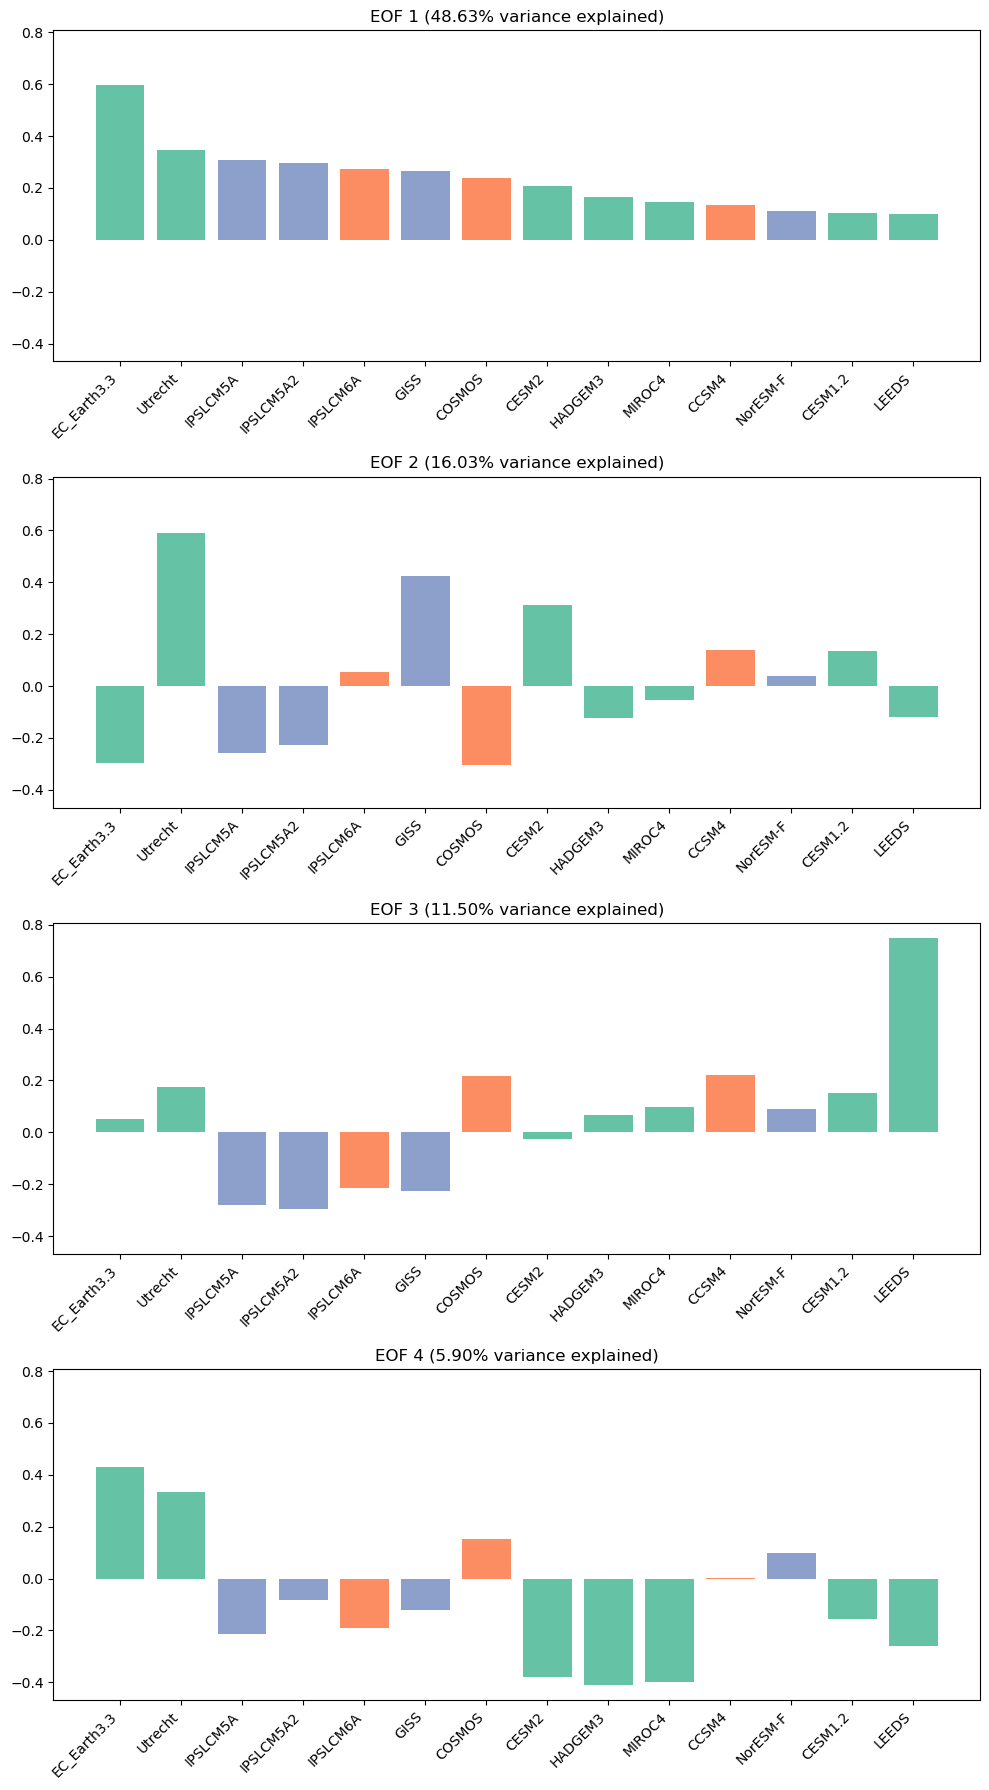

<Figure size 640x480 with 0 Axes>

In [40]:
# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")

# Extract latitude values
latitudes = ds['lat'].values

# Compute latitude weights (sqrt of cosine of latitude)
lat_weights = np.sqrt(np.cos(np.radians(latitudes)))

# Expand weights to match the data structure
lat_weights_2d = np.tile(lat_weights[:, np.newaxis], (ds.sizes['lev'], 1))  
lat_weights_flat = lat_weights_2d.flatten()[~nan_mask]  # Flatten and apply NaN mask

# Apply latitude weighting to the data
weighted_data = clean_data_matrix * lat_weights_flat[:, np.newaxis]

# Perform PCA on weighted data
pca = PCA(n_components=5)
pca_result = pca.fit_transform(weighted_data)
EOFs = pca.components_  # Shape: (num_EOFs, num_models)
print(EOFs.shape)

# Convert EOFs back to xarray (use 'model' as a dimension)
eof_ds = xr.Dataset({
    f'EOF{i+1}': (['model'], EOFs[i])
    for i in range(EOFs.shape[0])
}, coords={'model': models_to_keep})

# Define number of EOFs to visualize
num_components = min(4, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(10, 18), sharey=True)

# FIRST: Get the sorting order from EOF1
eof1_values = eof_ds['EOF1'].values
sorted_indices = np.argsort(eof1_values)[::-1]  # Descending order
sorted_models = np.array(models_to_keep)[sorted_indices]

# Define models to highlight and their colors
highlight_models = {
    'CESM2': '#66c2a5',
    'CESM1.2': '#66c2a5',
    'EC_Earth3.3': '#66c2a5',
    'HADGEM3_NEW_1997': '#66c2a5',
    'MIROC4_2004': '#66c2a5',
    'Utrecht_CESM1.0.5': '#66c2a5',
    'LEEDS': '#66c2a5',
    'CCSM4': '#fc8d62',
    'COSMOS': '#fc8d62',
    'IPSLCM6A_LR': '#fc8d62',
    'GISS': '#8da0cb',
    'NorESM-F': '#8da0cb',
    'IPSLCM5A': '#8da0cb',
    'IPSLCM5A2': '#8da0cb',
    
}

# Define model renames (only for the ones you want to change)
model_renames = {
    'Utrecht_CESM1.0.5': 'Utrecht',
    'HADGEM3_NEW_1997': 'HADGEM3',
    'IPSLCM6A_LR': 'IPSLCM6A',
    'MIROC4_2004' : 'MIROC4',
}

# Generate labels (only renames specified models)
renamed_models = [model_renames.get(model, model) for model in sorted_models]

# Plotting loop (now uses renamed_models for labels)
for i in range(num_components):
    ax = axes[i]
    sorted_eof_values = eof_ds[f'EOF{i+1}'].values[sorted_indices]
    colors = [highlight_models.get(model, 'steelblue') for model in sorted_models]  # Original names for colors
    
    # Plot with renamed labels
    ax.bar(renamed_models, sorted_eof_values, color=colors)
    ax.set_title(f'EOF {i+1} ({variance[i]:.2f}% variance explained)')
    ax.set_xticklabels(renamed_models, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Decomp_LatitudeVSDepth.pdf', dpi=300, bbox_inches="tight")
plt.show()

fig.suptitle('EOF Decomposition (Latitude VS. Depth)', 
             fontsize=16, fontweight='bold', y=1)

plt.tight_layout()
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Deconposition_LatitudeVSDepth.pdf', 
            dpi=300, bbox_inches="tight")
plt.show()